In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.integrate import trapz
from scipy.stats import norm, beta
from scipy.stats.mstats import mquantiles

In [2]:
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

# Laplace Noise Unidimensional

In [3]:
alphas = [1.0, 2.0, 5.0, 10.0, 50.0]
ndatas = [50, 200, 500, 1000]
# ndatas = [100, 1000]
algos = ["slice", "neal2", "neal2m5"]
nrep = 48

In [5]:
alphas

[1.0, 2.0, 5.0, 10.0, 50.0]

In [6]:
density_fname = "./unidimensional_laplace/out/{0}_ndata_{1}_alpha_{2:.6f}_rep_{3}_eval_dens.csv"

In [7]:
grid = np.linspace(-10, 10, 1000)
true_dens = 1/3 * norm.pdf(grid, loc=-5) + \
    1/3 * norm.pdf(grid, loc=0) + \
    1/3 * norm.pdf(grid, loc=5)

In [8]:
def eval_prior_mean(x, m=0, lam=0.1, a=3, b=3):
    sig_sq = tfd.InverseGamma(a, b).sample(50000)
    mu = tfd.Normal(0, np.sqrt(sig_sq / lam)).sample()
    dens = np.mean(tfd.Normal(mu, sig_sq).prob(x[:, None]), axis=1)
    return dens


prior_mean_dens = eval_prior_mean(grid)

In [9]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
from rpy2.robjects import default_converter
numpy2ri.activate()
decon = importr("decon")  

During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 


In [10]:
pert_data = np.loadtxt("unidimensional_laplace/out/_ndata_200_alpha_{0:.6f}_rep_0_sanitized_data.csv".format(alphas[0]))
pert_data.shape

(200,)

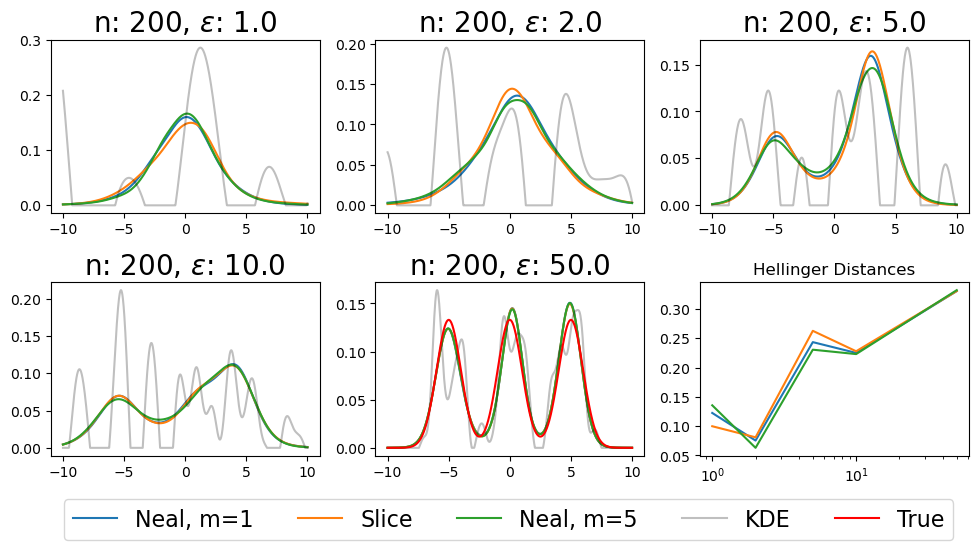

In [17]:
fig, axis = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))
axis = axis.flat

prior_dists = np.zeros((3, len(alphas)))

n = 200
for m, a in enumerate(alphas):
    neal_dens = np.exp(pd.read_csv(density_fname.format("neal2", n, a, 0)).values)
    neal5m_dens = np.exp(pd.read_csv(density_fname.format("neal2m5", n, a, 0)).values)
    slice_dens = np.exp(pd.read_csv(density_fname.format("slice", n, a, 0)).values)

    pert_data = np.loadtxt("unidimensional_laplace/out/_ndata_200_alpha_{0:.6f}_rep_0_sanitized_data.csv".format(a))
    eps = 20 / a
    deconv_dens = decon.DeconPdf(pert_data, eps, grid, bw="dboot2", error="laplacian")[1]
    deconv_dens = deconv_dens / trapz(deconv_dens, grid)

    # neal_q = mquantiles(neal_dens, prob=[0.5, 0.95], axis=0)
    # neal5m_q = mquantiles(neal5m_dens, prob=[0.5, 0.95], axis=0)
    # slice_q = mquantiles(slice_dens, prob=[0.5, 0.95], axis=0)

    slice_dens = np.mean(slice_dens, axis=0)
    neal_dens = np.mean(neal_dens, axis=0)
    neal5m_dens = np.mean(neal5m_dens, axis=0)

    prior_dists[0, m] = np.sqrt(0.5 * trapz((np.sqrt(neal_dens) - np.sqrt(prior_mean_dens))**2, grid))
    prior_dists[1, m] = np.sqrt(0.5 *trapz((np.sqrt(slice_dens) - np.sqrt(prior_mean_dens))**2, grid))
    prior_dists[2, m] = np.sqrt(0.5 *trapz((np.sqrt(neal5m_dens) - np.sqrt(prior_mean_dens))**2, grid))
    
    axis[m].plot(grid, neal_dens, label="Neal, m=1")
    axis[m].plot(grid, slice_dens, label="Slice")
    axis[m].plot(grid, neal5m_dens, label="Neal, m=5")
    axis[m].plot(grid, deconv_dens, label="KDE", color="black", alpha=0.25)

    # axis[m].fill_between(grid, neal_q[0, :], neal_q[1, :], alpha=0.2, color="steelblue")
    # axis[m].fill_between(grid, slice_q[0, :], slice_q[1, :], alpha=0.2, color="orange")
    # axis[m].fill_between(grid, neal5m_q[0, :], neal5m_q[1, :], alpha=0.2, color="forestgreen")

    if m == 4:
        axis[m].plot(grid, true_dens, color="red", label="True")
        
    axis[m].set_title(r"n: {0}, $\varepsilon$: {1}".format(n, a), fontsize=20)

plt.tight_layout()
# plt.legend()

axis[4].legend(ncol=5, fontsize=16, bbox_to_anchor=(-1.2, -0.55), loc="lower left")

for j in range(3):
    axis[-1].plot(alphas, prior_dists[j, :])
axis[-1].set_xscale("log")
axis[-1].set_title("Hellinger Distances")

plt.savefig("unidimensional_laplace/plots/dens_estimate_n200_dists.pdf", bbox_inches="tight")
plt.show()

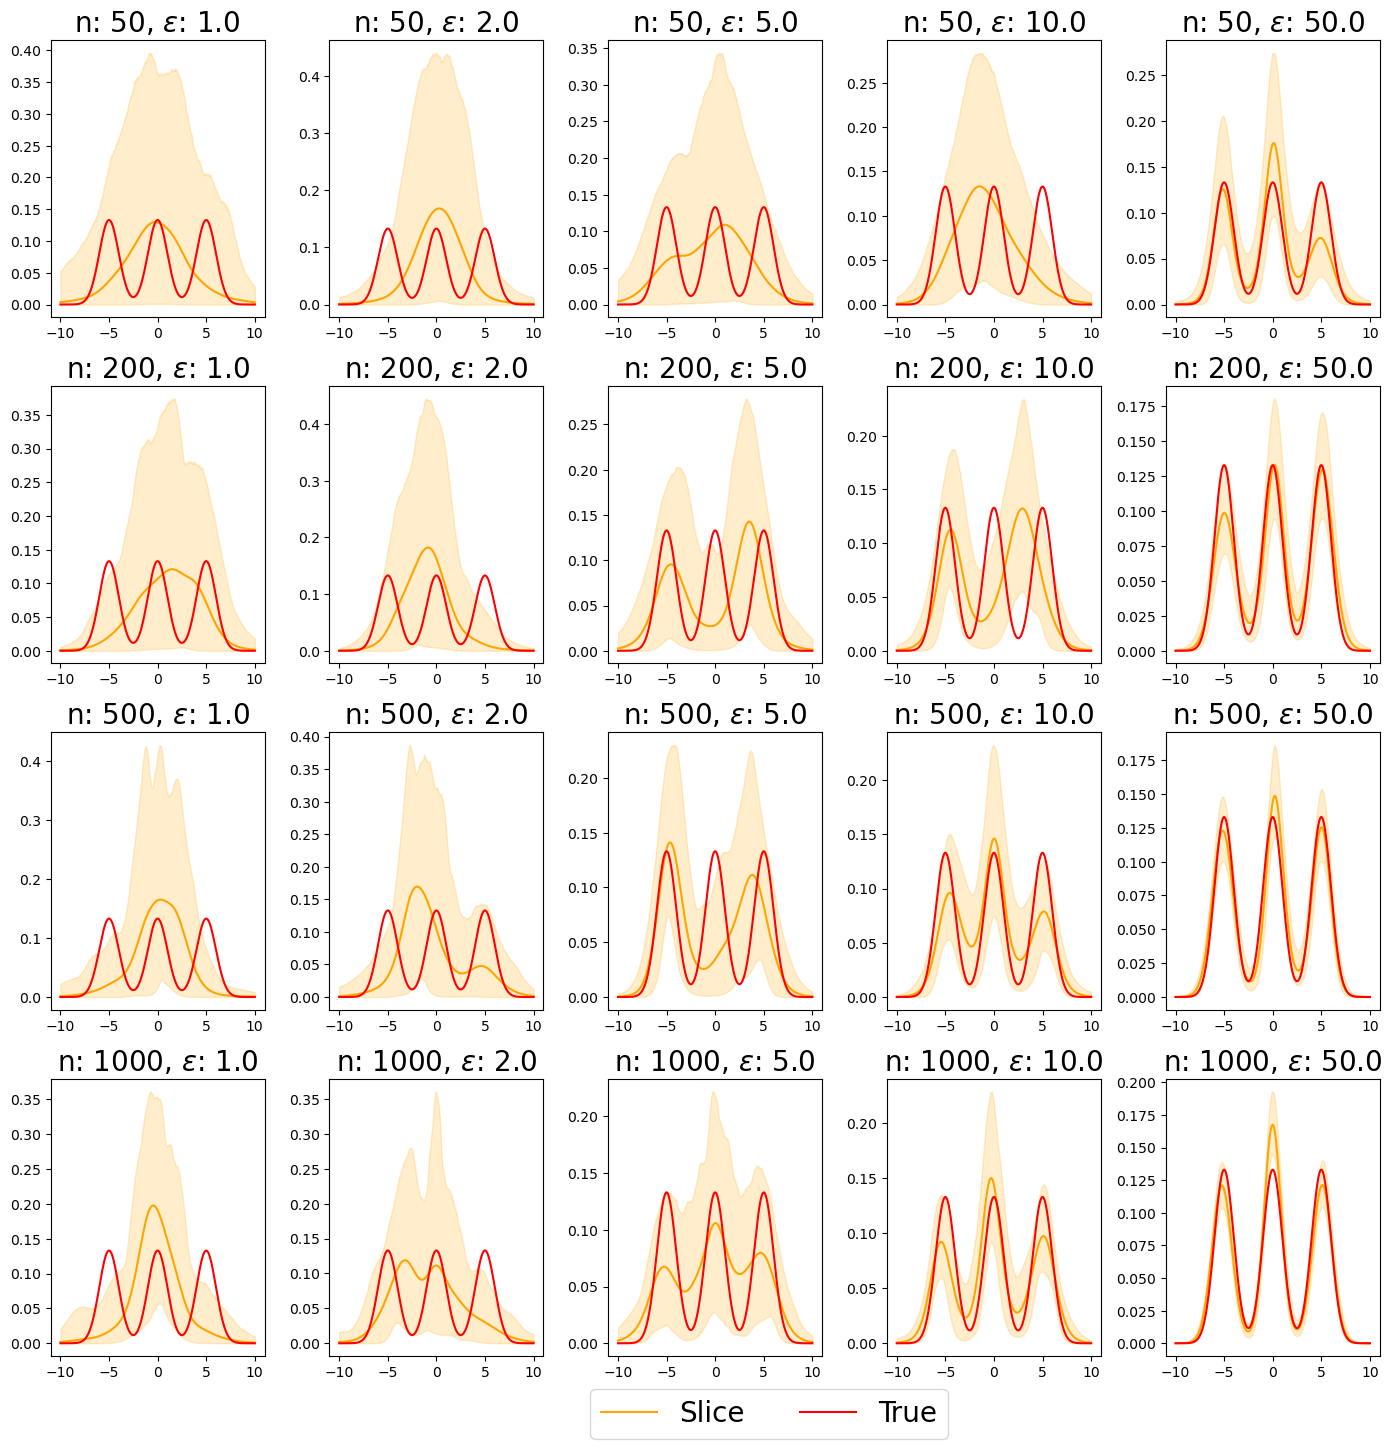

In [22]:
ndatas = [50, 200, 500, 1000]

fig, axis = plt.subplots(nrows=len(ndatas), ncols=len(alphas), figsize=(14, 14))

for l, n in enumerate(ndatas):
    for m, a in enumerate(alphas):
        # neal_dens = pd.read_csv(density_fname.format("neal2", n, a, 0))
        # neal5m_dens = pd.read_csv(density_fname.format("neal2m5", n, a, 0)).values
        slice_dens = np.exp(pd.read_csv(density_fname.format("slice", n, a, 0)))

        slice_q = mquantiles(slice_dens, prob=[0.025, 0.975], axis=0)

        # axis[l, m].plot(grid, np.mean(np.exp(neal_dens), axis=0), label="Neal")
        axis[l, m].plot(grid, np.mean(slice_dens, axis=0), label="Slice", color="orange")
        axis[l, m].fill_between(grid, slice_q[0, :], slice_q[1, :], alpha=0.2, color="orange")
        # axis[l, m].plot(grid, np.mean(np.exp(neal5m_dens), axis=0), label="Neal, m=5")
        axis[l, m].plot(grid, true_dens, color="red", label="True")
        axis[l, m].set_title(r"n: {0}, $\varepsilon$: {1}".format(n, a), fontsize=20)
        
plt.tight_layout()

axis[-1][2].legend(ncol=2, fontsize=20, bbox_to_anchor=(-0.15, -0.35), loc="lower left")
# plt.legend()
plt.savefig("unidimensional_laplace/plots/dens_estimate_ci.pdf", bbox_inches="tight")
plt.show()

In [ ]:
density_fname = "./unidimensional_laplace/out/ndata_{0}_eps_{1:.6f}_rep_{2}_eval_dens.csv"

grid = np.linspace(-15, 15, 1000)
true_dens = 1/3 * norm.pdf(grid, loc=-5) + \
    1/3 * norm.pdf(grid, loc=0) + \
    1/3 * norm.pdf(grid, loc=5)

hell_dists_means = []
hell_dists_sds = []

for eps in epsilons:
    print("eps: {0}".format(eps))
    errors = np.zeros(100)
    for i in range(100):
        try:
            dens = pd.read_csv(density_fname.format(250, eps, i), header=None).values
        except:
            continue
            
        mean_dens = np.mean(np.exp(dens), axis=0)
        errors[i] = trapz((np.sqrt(mean_dens) - np.sqrt(true_dens))**2, grid)
    hell_dists_means.append(np.mean(errors))
    hell_dists_sds.append(np.std(errors))

In [ ]:
hell_dists_means = np.array(hell_dists_means)
hell_dists_sds = np.array(hell_dists_sds)

In [ ]:
plt.plot(epsilons, hell_dists_means)
plt.fill_between(epsilons, hell_dists_means - hell_dists_sds, 
                 hell_dists_means + hell_dists_sds, alpha=0.3)
# plt.savefig("unidimensional_laplace/plots/hell_dists.pdf", bbox_inches="tight")

# Acceptance Rates

In [36]:
arate_fname = "./unidimensional_laplace/out/{0}_ndata_{1}_alpha_{2:.6f}_rep_{3}_acceptance_rate.csv"

slice_arate = np.zeros((len(ndatas), len(alphas)))
slice_low = np.zeros((len(ndatas), len(alphas)))
slice_up = np.zeros((len(ndatas), len(alphas)))


neal_arate = np.zeros((len(ndatas), len(alphas)))
neal_low = np.zeros((len(ndatas), len(alphas)))
neal_up = np.zeros((len(ndatas), len(alphas)))

neal5m_arate = np.zeros((len(ndatas), len(alphas)))
neal5m_low = np.zeros((len(ndatas), len(alphas)))
neal5m_up = np.zeros((len(ndatas), len(alphas)))


for l, n in enumerate(ndatas):
    for m, a in enumerate(alphas):
        curr_slice = []
        curr_neal = []
        curr_neal5m = []
        
        for i in range(nrep):
            curr_slice.append(
                pd.read_csv(arate_fname.format("slice", n, a, i), header=None).values[0, 0]) 
            curr_neal.append(
                pd.read_csv(arate_fname.format("neal2", n, a, i), header=None).values[0, 0]) 
            
            curr_neal5m.append(
                pd.read_csv(arate_fname.format("neal2m5", n, a, i), header=None).values[0, 0]) 
            
        slice_arate[l, m] = np.mean(curr_slice)
        slice_low[l, m], slice_up[l, m] = mquantiles(curr_slice, prob=[0.5, 0.95])
        
        neal_arate[l, m] = np.mean(curr_neal)
        neal_low[l, m], neal_up[l, m] = mquantiles(curr_neal, prob=[0.5, 0.95])
        
        neal5m_arate[l, m] = np.mean(curr_neal5m)
        neal5m_low[l, m], neal_up[l, m] = mquantiles(curr_neal5m, prob=[0.5, 0.95])

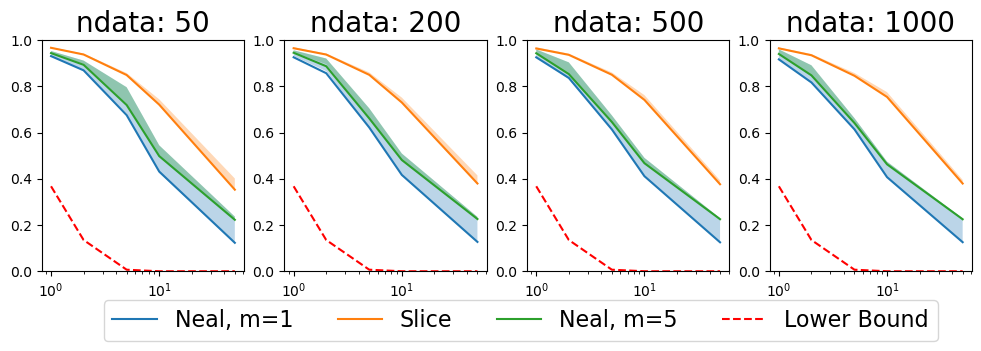

In [45]:
fig, axis = plt.subplots(nrows=1, ncols=len(ndatas), figsize=(12, 3))

for i in range(len(ndatas)):
    axis[i].plot(alphas, neal_arate[i, :], label="Neal, m=1")
    axis[i].fill_between(alphas, neal_low[i, :], neal_up[i, :], alpha=0.3)
    
    axis[i].plot(alphas, slice_arate[i, :], label="Slice")
    axis[i].fill_between(alphas, slice_low[i, :], slice_up[i, :], alpha=0.3)
    
    axis[i].plot(alphas, neal5m_arate[i, :], label="Neal, m=5")
    axis[i].fill_between(alphas, neal5m_low[i, :], neal_up[i, :], alpha=0.3)
    
    axis[i].plot(alphas, np.exp(-np.array(alphas)), "--", color="red", label="Lower Bound")
    axis[i].set_ylim(0, 1)
    axis[i].set_xticks(alphas)
    axis[i].set_xscale("log")
    axis[i].set_title("ndata: {0}".format(ndatas[i]), fontsize=20)
    
    
axis[2].legend(fontsize=(16), ncol=4, loc="lower left", bbox_to_anchor=(-2.15, -0.35))
# plt.savefig("unidimensional_laplace/new_plots/acceptance_rates.pdf", bbox_inches="tight")

# Effective Sample Sizes

In [12]:
nrep = 48

def get_ess(base_fname):
    out_neal = np.zeros((len(ndatas), len(alphas)))    
    out_slice = np.zeros((len(ndatas), len(alphas)))
    out_neal5m = np.zeros((len(ndatas), len(alphas)))
    
    
    
    for l, n in enumerate(ndatas):
        for m, a in enumerate(alphas):
            curr_slice = []
            curr_neal = []
            curr_neal5m = []
            
            for i in range(nrep):
                chain = pd.read_csv(base_fname.format("neal2", n, a, i), header=None).values[:, 0]
                curr_neal.append(az.ess(chain))
                
                chain = pd.read_csv(base_fname.format("slice", n, a, i), header=None).values[:, 0]
                curr_slice.append(az.ess(chain))
                
                chain = pd.read_csv(base_fname.format("neal2m5", n, a, i), header=None).values[:, 0]
                curr_neal5m.append(az.ess(chain))
                
            # print("eps: ", eps, "curr: ", curr)    
            out_neal[l, m] = np.median(curr_neal)
            out_slice[l, m] = np.median(curr_slice)
            out_neal5m[l, m] = np.median(curr_neal5m)
            
            
    return out_neal, out_slice, out_neal5m

In [13]:
nclus_fname = "/Users/marioberaha/dev/bayesmix_origin/privacy_experiments/unidimensional_laplace/out/{0}_ndata_{1}_alpha_{2:.6f}_rep_{3}_nclus_chain.csv"
nclus_ess_neal, nclus_ess_slice, nclus_ess_neal5m = get_ess(nclus_fname)

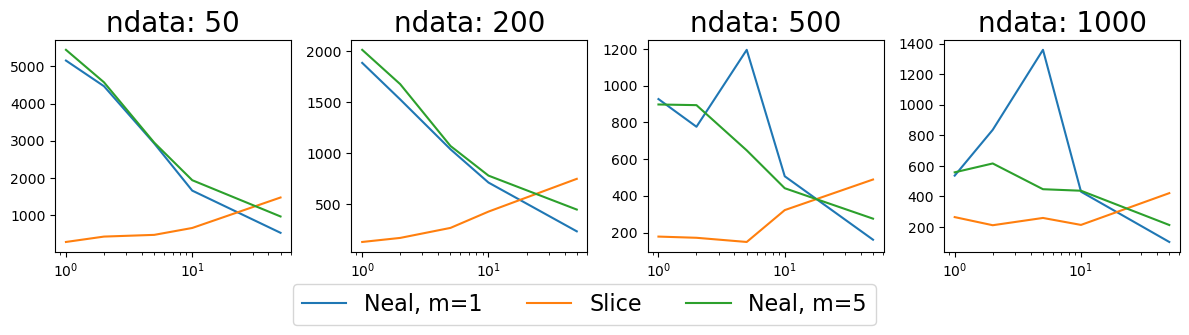

In [16]:
fig, axis = plt.subplots(nrows=1, ncols=len(ndatas), figsize=(12, 3))

for i in range(len(ndatas)):
    axis[i].plot(alphas, 10 * nclus_ess_neal[i, :], label="Neal, m=1")
    axis[i].plot(alphas, 10 * nclus_ess_slice[i, :], label="Slice")
    axis[i].plot(alphas, 10 * nclus_ess_neal5m[i, :], label="Neal, m=5")
    axis[i].set_title("ndata: {0}".format(ndatas[i]), fontsize=20)
    axis[i].set_xticks(alphas)
    axis[i].set_xscale("log")

plt.tight_layout()

axis[2].legend(fontsize=(16), ncol=3, loc="lower left", bbox_to_anchor=(-1.55, -0.40))
plt.savefig("unidimensional_laplace/plots/nclus_ess.pdf", bbox_inches="tight")

In [ ]:
fig, axis = plt.subplots(nrows=1, ncols=len(ndatas), figsize=(12, 5))

for i in range(len(ndatas)):
    axis[i].plot(alphas, nclus_ess_neal[i, :] / neal_times[i, :], label="Neal")
    axis[i].plot(alphas, nclus_ess_slice[i, :] / slice_times[i, :], label="Slice")
    axis[i].set_title("ndata: {0}".format(ndatas[i]), fontsize=20)
    axis[i].set_xticks(alphas)
    axis[i].set_xscale("log")
    
axis[1].legend(fontsize=(16))
plt.savefig("unidimensional_laplace/new_plots/nclus_ess_time.pdf", bbox_inches="tight")

In [ ]:
fig, axis = plt.subplots(nrows=len(ndatas), ncols=len(alphas), figsize=(15, 18))

for l, n in enumerate(ndatas):
    for m, a in enumerate(alphas):
        neal_nclus = pd.read_csv(nclus_fname.format("neal2", n, a, 0)).values
        nc, w = np.unique(neal_nclus, return_counts=True)
        axis[l, m].bar(nc, w / w.sum(), label="Neal", alpha=0.5)
        
        slice_nclus = pd.read_csv(nclus_fname.format("slice", n, a, 0)).values
        nc, w = np.unique(slice_nclus, return_counts=True)
        axis[l, m].bar(nc, w / w.sum(), label="Slice", alpha=0.5)

        axis[l, m].set_title(r"n: {0}, $\varepsilon$: {1}".format(n, a), fontsize=16)
# plt.legend()
plt.tight_layout()
plt.savefig("unidimensional_laplace/new_plots/nclus_hist.pdf", bbox_inches="tight")
plt.show()

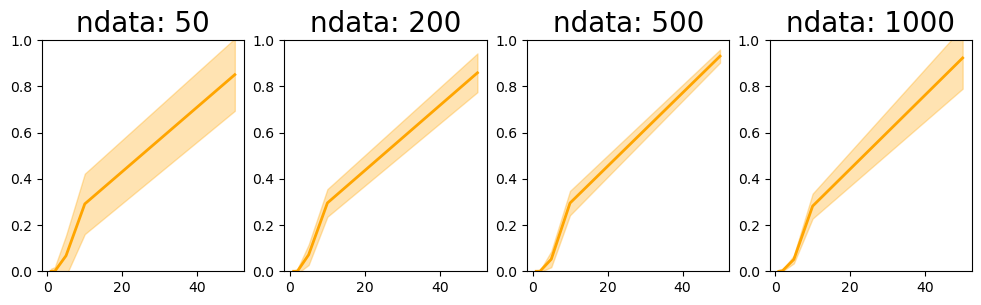

In [11]:
from sklearn.metrics import adjusted_rand_score as ari


alphas = [1.0, 2.0, 5.0, 10.0, 50.0]
ndatas = [50, 200, 500, 1000]
# ndatas = [100, 1000]
algos = ["slice", "neal2", "neal2m5"]
nrep = 48

fig, axis = plt.subplots(1, ncols=len(ndatas), figsize=(12, 3))

bestclus_fname = "./unidimensional_laplace/out/{0}_ndata_{1}_alpha_{2:.6f}_rep_{3}_best_clus.csv"
trueclus_fname = "./unidimensional_laplace/out/ndata_{0}_rep_{1}trueclus.csv"

for l, n in enumerate(ndatas):
    slice_aris = np.zeros((len(alphas), nrep))
    for m, a in enumerate(alphas):
        curr_slice = []
        curr_neal = []
        for i in range(nrep):
            true_clus = pd.read_csv(trueclus_fname.format(n, i)).values[:, 0]
            slice_bestclus = pd.read_csv(bestclus_fname.format("slice", n, a, i)).values[:, 0]
            slice_aris[m, i] = ari(true_clus, slice_bestclus)
    
    slice_std = np.std(slice_aris, axis=1)
    slice_m = np.median(slice_aris, axis=1)
    axis[l].plot(alphas, slice_m, color="orange", label="Slice", lw=2)
    axis[l].fill_between(alphas, slice_m - slice_std, slice_m + slice_std, color="orange", alpha=0.3)

    axis[l].set_title("ndata: {0}".format(n), fontsize=20)
    axis[l].set_ylim(0.0, 1.0)


# plt.tight_layout()
plt.savefig("unidimensional_laplace/plots/ari.pdf", bbox_inches="tight")
plt.show()

In [7]:
slice_aris.shape

(5, 48)

In [ ]:
plt.plot(epsilons, nclus_ess_means)
plt.fill_between(epsilons, nclus_ess_means - nclus_ess_sds, 
                 nclus_ess_means + nclus_ess_sds, alpha=0.3)
#plt.savefig("unidimensional_laplace/plots/nclus_ess.pdf", bbox_inches="tight")

In [ ]:
entropy_fname = "./unidimensional_laplace/out/{0}_ndata_{1}_alpha_{2:.6f}_rep_{3}_entropy_chain.csv"

entropy_neal, entropy_slice = get_ess(entropy_fname)

In [ ]:
plt.plot(alphas, entropy_ess_means)
plt.fill_between(epsilons, entropy_ess_means - entropy_ess_sds, 
                 entropy_ess_means + entropy_ess_sds, alpha=0.3)
# plt.savefig("unidimensional_laplace/plots/entropy_ess.pdf", bbox_inches="tight")

In [ ]:
loglik_fname = "./unidimensional_laplace/out/{0}_ndata_{1}_alpha_{2:.6f}_rep_{3}_loglik_chain.csv"
loglik_neal, loglik_slice = get_ess(loglik_fname)

In [ ]:
fig, axis = plt.subplots(nrows=1, ncols=len(ndatas), figsize=(12, 5))

for i in range(len(ndatas)):
    axis[i].plot(alphas, loglik_neal[i, :], label="Neal")
    axis[i].plot(alphas, loglik_slice[i, :], label="Slice")
    axis[i].set_title("ndata: {0}".format(ndatas[i]), fontsize=20)
    axis[i].set_xticks(alphas)
    axis[i].set_xscale("log")
    axis[i].set_yscale("log")
    
axis[1].legend(fontsize=(16))
plt.savefig("unidimensional_laplace/new_plots/loglik_ess.pdf", bbox_inches="tight")

In [ ]:
fig, axis = plt.subplots(nrows=1, ncols=len(ndatas), figsize=(12, 5))

for i in range(len(ndatas)):
    axis[i].plot(alphas, loglik_neal[i, :] / neal_times[i, :], label="Neal")
    axis[i].plot(alphas, loglik_slice[i, :]/ slice_times[i, :], label="Slice")
    axis[i].set_title("ndata: {0}".format(ndatas[i]), fontsize=20)
    axis[i].set_xticks(alphas)
    axis[i].set_xscale("log")
    
axis[1].legend(fontsize=(16))
plt.savefig("unidimensional_laplace/new_plots/loglik_time_ess.pdf", bbox_inches="tight")

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

axes = axes.flat

chain = pd.read_csv(loglik_fname.format(250, 2.0, 1), header=None).values[:, 0]
ess = az.ess(chain)
axes[0].plot(chain)
axes[0].set_title("eps: {0}, replica: {1}, ess: {2:.2f}".format(2, 1, ess))

chain = pd.read_csv(loglik_fname.format(250, 2.0, 39), header=None).values[:, 0]
ess = az.ess(chain)
axes[1].plot(chain)
axes[1].set_title("eps: {0}, replica: {1}, ess: {2:.2f}".format(2, 39, ess))

chain = pd.read_csv(loglik_fname.format(250, 0.1, 1), header=None).values[:, 0]
ess = az.ess(chain)
axes[2].plot(chain)
axes[2].set_title("eps: {0}, replica: {1}, ess: {2:.2f}".format(0.1, 1, ess))

chain = pd.read_csv(loglik_fname.format(250, 0.1, 39), header=None).values[:, 0]
ess = az.ess(chain)
axes[3].plot(chain)
axes[3].set_title("eps: {0}, replica: {1}, ess: {2:.2f}".format(0.1, 39, ess))

plt.savefig("unidimensional_laplace/plots/loglik_chains.pdf", bbox_inches="tight")

In [ ]:
plt.plot(epsilons, loglik_ess_means)
plt.fill_between(epsilons, loglik_ess_means - loglik_ess_sds, 
                 loglik_ess_means + loglik_ess_sds, alpha=0.3)
plt.savefig("unidimensional_laplace/plots/loglik_ess.pdf", bbox_inches="tight")

In [ ]:
l2err_fname = "./unidimensional_laplace/out/ndata_{0}_eps_{1:.6f}_rep_{2}_l2error_chain.csv"

l2_err_means = []
l2_err_sds = []

for eps in epsilons:
    curr = []
    for i in range(100):
        try:
            chain = pd.read_csv(l2err_fname.format(250, eps, i), header=None).values[:, 0]
        except:
            continue

        curr.append(np.mean(chain))
    
    l2_err_means.append(np.mean(curr))
    l2_err_sds.append(np.std(curr))
    
l2_err_means = np.array(l2_err_means)
l2_err_sds = np.array(l2_err_sds)

In [ ]:
l2_err_means

In [ ]:
plt.plot(epsilons, l2_err_means)
plt.fill_between(epsilons, l2_err_means - l2_err_sds, 
                 l2_err_means + l2_err_sds, alpha=0.3)

plt.savefig("unidimensional_laplace/plots/l2_errs.pdf", bbox_inches="tight")

In [ ]:
l2err_fname = "./unidimensional_laplace/out/ndata_{0}_eps_{1:.6f}_rep_{2}_l2error_chain.csv"

l2err_ess_means, l2err_ess_sds = get_ess(l2err_fname)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

axes = axes.flat

chain = pd.read_csv(l2err_fname.format(250, 1.0, 1), header=None).values[:, 0]
ess = az.ess(chain)
axes[0].plot(chain)
axes[0].set_title("eps: {0}, replica: {1}, ess: {2:.2f}".format(1, 75, ess))

chain = pd.read_csv(l2err_fname.format(250, 1.0, 39), header=None).values[:, 0]
ess = az.ess(chain)
axes[1].plot(chain)
axes[1].set_title("eps: {0}, replica: {1}, ess: {2:.2f}".format(1, 36, ess))

chain = pd.read_csv(l2err_fname.format(250, 0.1, 1), header=None).values[:, 0]
ess = az.ess(chain)
axes[2].plot(chain)
axes[2].set_title("eps: {0}, replica: {1}, ess: {2:.2f}".format(0.1, 1, ess))

chain = pd.read_csv(l2err_fname.format(250, 0.1, 39), header=None).values[:, 0]
ess = az.ess(chain)
axes[3].plot(chain)
axes[3].set_title("eps: {0}, replica: {1}, ess: {2:.2f}".format(0.1, 39, ess))

plt.savefig("unidimensional_laplace/plots/l2err_chains.pdf", bbox_inches="tight")

In [ ]:
eps = 0.01
i = 30
curr = pd.read_csv(l2err_fname.format(250, eps, i), header=None).values[:, 0]
az.ess(curr)

In [ ]:
plt.plot(epsilons, l2err_ess_means)

In [ ]:
plt.plot(epsilons, l2err_ess_means)
plt.fill_between(epsilons, l2err_ess_means - l2err_ess_sds, 
                 l2err_ess_means + l2err_ess_sds, alpha=0.3)
plt.savefig("unidimensional_laplace/plots/l2err_ess.pdf", bbox_inches="tight")

In [ ]:
l2err_ess_means

# Wavelet

In [ ]:
grid = np.linspace(0.0, 1.0, 1000)
true_dens = 1/3 * (
    beta.pdf(grid, 5, 50) +
    beta.pdf(grid, 50, 50) +
    beta.pdf(grid, 50, 5)
)
plt.plot(grid, true_dens)

In [ ]:
JS = [2, 4, 6]
alphas = np.array([2.0, 10.0, 50.0, 100.0, 250.0])
nrep = 1

In [ ]:
base_wav_fname = "./wavelets/out/wavelet_j_{0}_ndata_{1}_alpha_{2:.6f}_rep_{3}_{4}.csv"
base_lap_fname = "./wavelets/out/laplace_ndata_{0}_alpha_{1:.6f}_rep_{2}_{3}.csv"

wav_arates = np.zeros((len(JS), len(alphas), nrep))
lap_arates = np.zeros((len(alphas), nrep))

for m, a in enumerate(alphas):
    for n in range(nrep):
        lap_arates[m, n] = np.loadtxt(base_lap_fname.format(250, a, n, "acceptance_rate"), delimiter=",")
        for l, j in enumerate(JS):
            curr_fname = base_wav_fname.format(j, 250, a, n, "acceptance_rate")
            wav_arates[l, m, n] = np.loadtxt(curr_fname, delimiter=",")

In [ ]:
colors = ["orange", "forestgreen", "red"]

plt.plot(alphas, np.median(lap_arates, axis=-1), label="Laplace")

for l, j in enumerate(JS):
    plt.plot(alphas, np.median(wav_arates[l, :, :], axis=-1), label="j: {0}".format(j), color=colors[l])

plt.plot(alphas, np.exp(-alphas), "--", color=colors[l])

plt.ylim(0, 1)
plt.xticks(alphas)
plt.xscale("log")

plt.legend(fontsize=14)
plt.savefig("./wavelets/plots/bgg_acceptance_rates.pdf", bbox_inches="tight")

In [ ]:
fig, axis = plt.subplots(nrows=2, ncols=len(alphas), figsize=(14, 6.5))

JS = [2, 4, 6]

for m, a in enumerate(alphas):
    for l, j in enumerate(JS):
        dens = pd.read_csv(base_wav_fname.format(j, 250, a, 0, "eval_dens"))        
        axis[0, m].plot(grid, np.mean(np.exp(dens), axis=0), label="j: {0}".format(j))
    
    axis[0, m].set_title(r"Wavelet, $\alpha$: {0}".format(a))
    axis[0, m].plot(grid, true_dens, color="red")
    
    dens = pd.read_csv(base_lap_fname.format(250, a, 0, "eval_dens")) 
    axis[1, m].plot(grid, np.mean(np.exp(dens), axis=0))
    axis[1, m].set_title(r"Laplace, $\alpha$: {0}".format(a))
    axis[1, m].plot(grid, true_dens, color="red")
        
#plt.tight_layout()
axis[0, 2].legend()
plt.savefig("wavelets/plots/dens_estimate.pdf", bbox_inches="tight")
plt.show()

In [ ]:
dens_fname = "./wavelets/out_bgg/ndata_{0}_eps_{1:.6f}_j_{2}_rep_{3}_eval_dens.csv"
l2err = np.zeros((len(JS), len(eps)))

for l, j in enumerate(JS):
    for m, e in enumerate(eps):
        curr_fname = l2err_fname.format(250, e, j, 0)
        l2err[l, m] = np.mean(np.loadtxt(curr_fname, delimiter=","))

In [ ]:
dens_fname = "./wavelets/out_bgg/ndata_{0}_eps_{1:.6f}_j_{2}_rep_{3}_eval_dens.csv"
fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(17, 5))

for l, j in enumerate(JS):
    for e in eps:
        curr_fname = dens_fname.format(250, e, j, 0)
        dens =  pd.read_csv(curr_fname, header=None).values
        axis[l].plot(xgrid, np.mean(np.exp(dens), axis=0), label=r"$\sigma_j$: {0}".format(e))
        
    axis[l].plot(xgrid, true_dens, color="red")
    axis[l].set_title("J: {0}".format(j), fontsize=18) 

axis[1].legend(ncol=4, loc="lower center", fontsize=18, bbox_to_anchor=[0.3, -0.4])
  
plt.savefig("./wavelets/plots/bgg_dens.pdf", bbox_inches="tight")

# Gaussian

In [17]:
alphas = sorted([50.0, 25.0, 10.0, 5.0])
deltas = sorted([0.25, 0.1, 0.01])
nrep = 48

grid = np.linspace(-10, 10, 1000)
true_dens = 1/3 * norm.pdf(grid, loc=-5) + \
    1/3 * norm.pdf(grid, loc=0) + \
    1/3 * norm.pdf(grid, loc=5)

In [18]:
def get_sig(alpha, delta):
    return np.sqrt(2 * np.log(1.25 / delta)) * 20 / alpha


get_sig(1.0, 0.01) ** 2

3862.6509898418412

In [21]:
base_fname = "gaussian/out/{0}_ndata_250_alpha_{1:.6f}_delta_{2:.6f}_rep_{3}_{4}.csv"

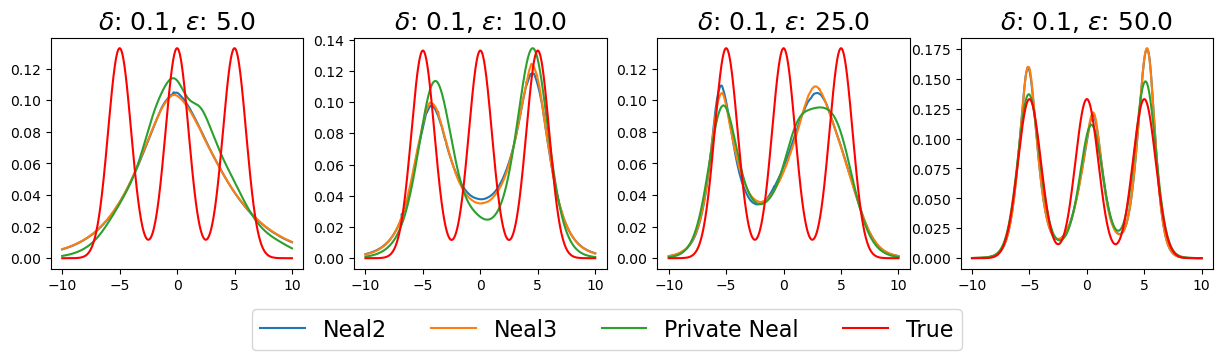

In [6]:
fig, axis = plt.subplots(nrows=1, ncols=len(alphas), figsize=(15, 3))

d = 0.1

for m, a in enumerate(alphas):
    neal2_dens = pd.read_csv(base_fname.format("neal2", a, d, 0, "eval_dens"))
    neal3_dens = pd.read_csv(base_fname.format("neal3", a, d, 0, "eval_dens"))
    privneal2_dens = pd.read_csv(base_fname.format("privateneal2", a, d, 0, "eval_dens"))

    axis[ m].plot(grid, np.mean(np.exp(neal2_dens), axis=0), label="Neal2")
    axis[m].plot(grid, np.mean(np.exp(neal3_dens), axis=0), label="Neal3")
    axis[m].plot(grid, np.mean(np.exp(privneal2_dens), axis=0), label="Private Neal")
    axis[m].plot(grid, true_dens, color="red", label="True")
    axis[m].set_title(r"$\delta$: {0}, $\varepsilon$: {1}".format(d, a), fontsize=18)

axis[1].legend(ncol=4, fontsize=16, loc="lower center",  bbox_to_anchor=(1.0, -0.4))
# plt.tight_layout()

plt.savefig("gaussian/plots/dens_estimate_delta0_1.pdf", bbox_inches="tight")
plt.show()

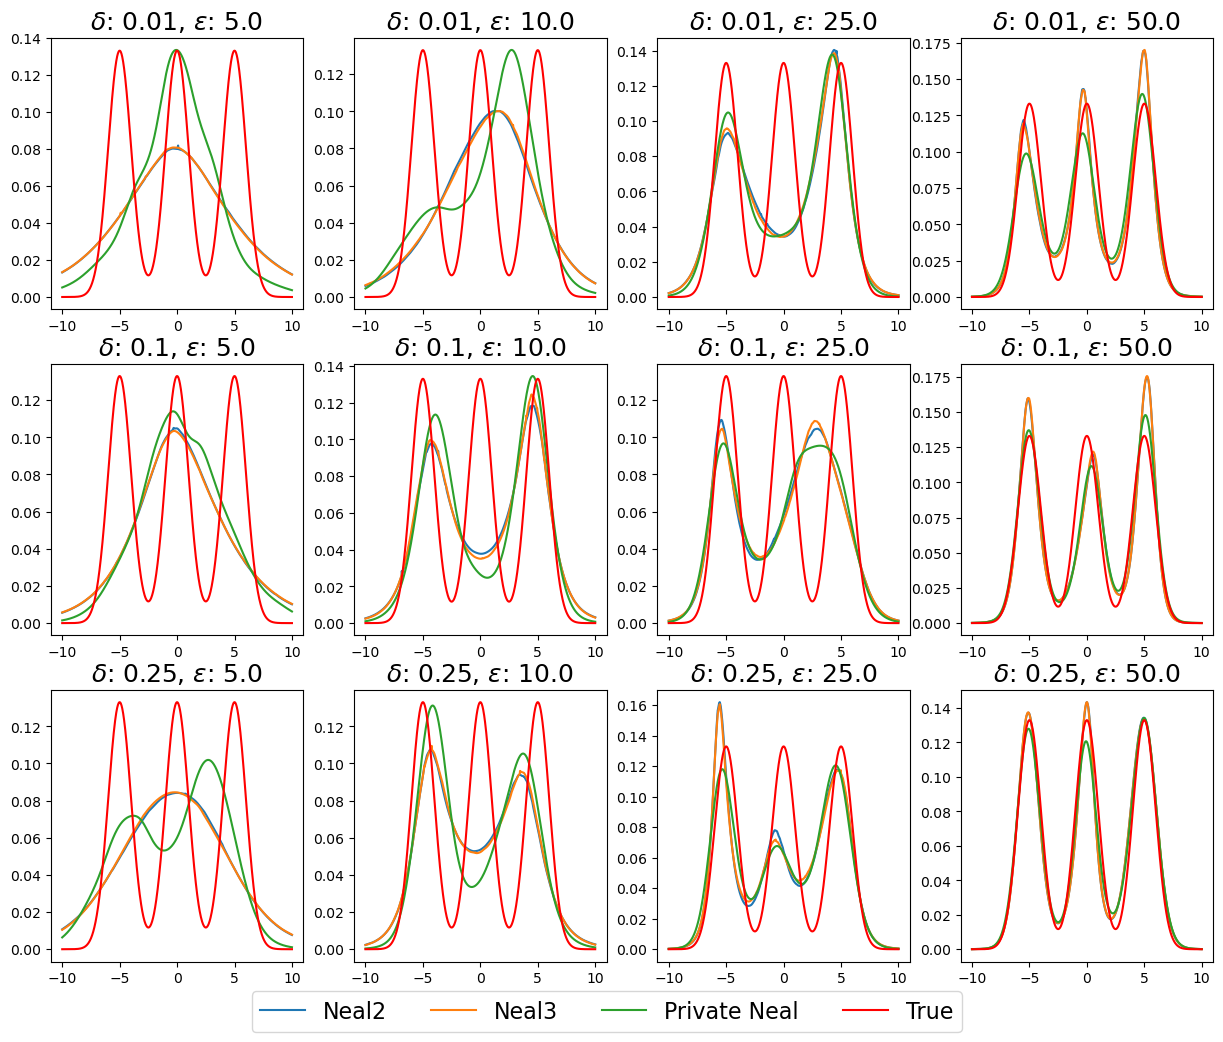

In [8]:
fig, axis = plt.subplots(nrows=len(deltas), ncols=len(alphas), figsize=(15, 12))


for l, d in enumerate(deltas):
    for m, a in enumerate(alphas):
        neal2_dens = pd.read_csv(base_fname.format("neal2", a, d, 0, "eval_dens"))
        neal3_dens = pd.read_csv(base_fname.format("neal3", a, d, 0, "eval_dens"))
        privneal2_dens = pd.read_csv(base_fname.format("privateneal2", a, d, 0, "eval_dens"))
        
        axis[l, m].plot(grid, np.mean(np.exp(neal2_dens), axis=0), label="Neal2")
        axis[l, m].plot(grid, np.mean(np.exp(neal3_dens), axis=0), label="Neal3")
        axis[l, m].plot(grid, np.mean(np.exp(privneal2_dens), axis=0), label="Private Neal")
        axis[l, m].plot(grid, true_dens, color="red", label="True")
        axis[l, m].set_title(r"$\delta$: {0}, $\varepsilon$: {1}".format(d, a), fontsize=18)

axis[-1, 1].legend(ncol=4, fontsize=16, loc="lower center",  bbox_to_anchor=(1.0, -0.3))
# plt.tight_layout()

plt.savefig("gaussian/plots/dens_estimate.pdf", bbox_inches="tight")
plt.show()

In [23]:
def get_nclus_ess(base_fname):
    out_neal2 = np.zeros((len(deltas), len(alphas), nrep))
    out_neal3 = np.zeros((len(deltas), len(alphas), nrep))
    out_privneal = np.zeros((len(deltas), len(alphas), nrep))

    for l, d in enumerate(deltas):
        for m, a in enumerate(alphas):
            for i in range(nrep):
            
                chain = pd.read_csv(
                    base_fname.format("neal2", a, d, i, "nclus_chain"), header=None).values[:, 0]
                out_neal2[l, m, i] = az.ess(chain)

                chain = pd.read_csv(
                    base_fname.format("neal3", a, d, i, "nclus_chain"), header=None).values[:, 0]
                out_neal3[l, m, i] = az.ess(chain)

                chain = pd.read_csv(
                    base_fname.format("privateneal2", a, d, i, "nclus_chain"), header=None).values[:, 0]
                out_privneal[l, m, i] = az.ess(chain)
    
    out_neal2 = np.mean(out_neal2, axis=-1)
    out_neal3 = np.mean(out_neal3, axis=-1)
    out_privneal = np.mean(out_privneal, axis=-1)
    
    return out_neal2, out_neal3, out_privneal

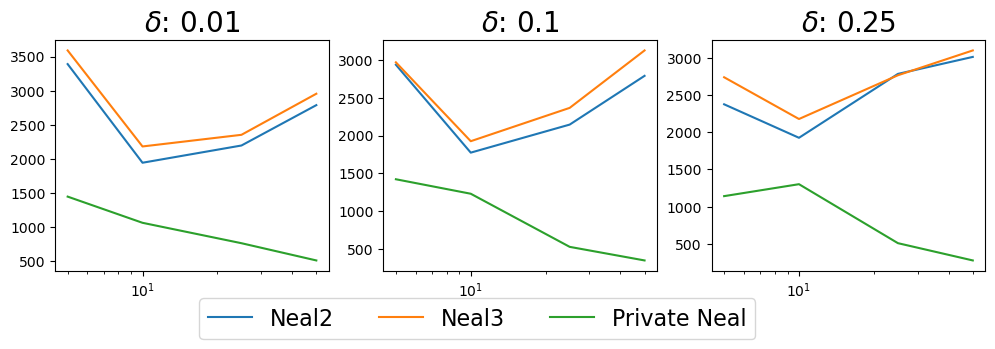

In [24]:
neal2_ess, neal3_ess, privneal_ess = get_nclus_ess(base_fname)

fig, axis = plt.subplots(nrows=1, ncols=len(deltas), figsize=(12, 3))

for i in range(len(deltas)):
    axis[i].plot(alphas, 10 * neal2_ess[i, :], label="Neal2")
    axis[i].plot(alphas, 10 * neal3_ess[i, :], label="Neal3")
    axis[i].plot(alphas, 10 * privneal_ess[i, :], label="Private Neal")
    axis[i].set_title(r"$\delta$: {0}".format(deltas[i]), fontsize=20)
    axis[i].set_xticks(alphas)
    axis[i].set_xscale("log")
    
axis[1].legend(fontsize=(16), ncol=3, bbox_to_anchor=(1.4, -0.07))
plt.savefig("gaussian/plots/nclus_ess.pdf", bbox_inches="tight")

# Global

In [ ]:
grid = np.linspace(0.0, 1.0, 1000)
true_dens = 1/3 * (
    beta.pdf(grid, 5, 50) +
    beta.pdf(grid, 50, 50) +
    beta.pdf(grid, 50, 5)
)
plt.plot(grid, true_dens)

In [ ]:
alphas = np.array([2.0, 10.0, 50.0, 100.0, 250.0])
nrep = 1

base_marg_fname = "./global/out/_neal2_histogram_ndata_{0}_alpha_{1:.6f}_rep_{2}_{3}.csv"
base_cond_fname = "./global/out/_slice_histogram_ndata_{0}_alpha_{1:.6f}_rep_{2}_{3}.csv"

In [ ]:
hist_arates = np.zeros((len(alphas), nrep))

for m, a in enumerate(alphas):
    for n in range(nrep):
        hist_arates[m, n] = np.loadtxt(base_hist_fname.format(250, a, n, "acceptance_rate"), delimiter=",")

In [ ]:
colors = ["orange", "forestgreen", "red"]

plt.plot(alphas, np.median(hist_arates, axis=-1), label="Laplace")

plt.plot(alphas, np.exp(-alphas), "--")

plt.ylim(0, 1)
plt.xticks(alphas)
plt.xscale("log")

plt.legend(fontsize=14)
# plt.savefig("./wavelets/plots/bgg_acceptance_rates.pdf", bbox_inches="tight")

In [ ]:
fig, axis = plt.subplots(nrows=1, ncols=len(alphas), figsize=(14, 3))

for m, a in enumerate(alphas):
    dens = pd.read_csv(base_marg_fname.format(250, a, 0, "eval_dens")) 
    axis[m].plot(grid, np.mean(np.exp(dens), axis=0), label="Neal")
    dens = pd.read_csv(base_cond_fname.format(250, a, 0, "eval_dens")) 
    axis[m].plot(grid, np.mean(np.exp(dens), axis=0), label="Slice")
    axis[m].set_title(r"$\varepsilon$: {0}".format(a), fontsize=16)
    axis[m].plot(grid, true_dens, color="red", label="True")
        
#plt.tight_layout()
axis[2].legend(ncol=3, loc="lower left", bbox_to_anchor=(-0.6, -0.35), fontsize=15)
plt.savefig("global/plots/dens_estimate2_l2_smallparams.pdf", bbox_inches="tight")
plt.show()

In [ ]:
4700+5610+717+2200+3272+4730+2651

In [ ]:
logprobs = np.ones(10) * 1e-12
logprobs[0] = 1.0

probs = np.zeros_like(logprobs)
for k in range(len(logprobs)):
    probs[k] = 1 / np.sum(np.exp(logprobs - logprobs[k]))
print(probs)



In [ ]:
from scipy.special import softmax

softmax(logprobs)

In [ ]:
logprobs

In [ ]:
np.exp(logprobs) / np.sum(np.exp(logprobs))

In [ ]:
from bayesmixpy import run_mcmc

means = np.array([-5, 0, 5])
probas = np.array([1, 1, 1]) / 3
c = np.sort(np.random.choice(3, p=probas, size=200))
conf_data = np.random.normal(means[c])
public_data = conf_data + np.random.laplace(scale=20/10, size=200)

In [ ]:
plt.hist(public_data, bins=20, alpha=0.4)
plt.hist(conf_data, bins=20, alpha=0.4)

In [ ]:
dp = """
fixed_value {
    totalmass: 4.0
}
"""

g0 = """
fixed_values {
    mean: 0.0
    var_scaling: 0.05
    shape: 4.0
    scale: 4.0
}
"""

algo = """
algo_id: "Neal2"
rng_seed: 20201124
iterations: 2000
burnin: 1000
init_num_clusters: 3
"""

In [ ]:
eval_dens_weird, _, _, _, _ = run_mcmc(
    "NNIG", "DP", public_data, g0, dp, algo, grid,
    return_clusters=False, return_num_clusters=False,
    return_best_clus=False)

In [ ]:
n = 200
a = 10

fig = plt.figure()

neal_dens = pd.read_csv(density_fname.format("neal2", n, a, 0))
plt.plot(grid, np.mean(np.exp(neal_dens), axis=0), label="Neal")
plt.plot(grid, np.mean(np.exp(eval_dens_weird), axis=0), label="No Privacy", color="forestgreen")
plt.plot(grid, true_dens, color="red", label="True")
plt.title(r"n: {0}, $\varepsilon$: {1}".format(n, a), fontsize=20)
plt.legend(fontsize=(16), ncol=3, loc="lower left", bbox_to_anchor=(-.03, -0.25))

plt.savefig("unidimensional_laplace/new_plots/example_no_privacy.pdf", bbox_inches="tight")